In [99]:
!pip install -U evaluate
!pip install -U datasets
!pip install -U accelerate
!pip install -U transformers
!pip install -U scikit-learn
!pip install -U matplotlib
!pip install -U seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 413.9 kB/s eta 0:00:00a 0:00:01


In [67]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import evaluate
from matplotlib import pyplot as plt
import seaborn as sns
import csv
from collections import defaultdict
from datasets import Dataset

In [68]:
OUTPUT_DIR = 'output'
VAL_RATIO = 0.3
DATA_COLUMNS = ['title', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'label', 'context_score', 'trigger_words']
LABEL_COLUMN = 'category'
DATASET_DIR = 'data/full_maven_with_category.csv'

## Load Dataset

In [69]:

def load_dataset(file_location, target_column):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_location)
    labels = sorted(list(df[target_column].unique()))
    print(len(labels))

    #convert labels in target column to numbers
    df[target_column] = df[target_column].apply(lambda x: labels.index(x))

    return df, labels

In [70]:
data_df, label_list = load_dataset(DATASET_DIR, LABEL_COLUMN)
train_data, test_data, train_labels, test_labels = train_test_split(data_df, data_df[LABEL_COLUMN], test_size=VAL_RATIO, random_state=42)

15


In [71]:
data_df.head()

,title,word_count,character_count,bigrams,lemma,pos,tag,dep,label,context_score,trigger_words,category
0,Battle of Salis,3,15,"[('Battle', 'of'), ('of', 'Salis')]","['battle', 'of', 'Salis']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['', '', '']","{'battle': 1.0, 'salis': 0.008540730727941325}","['battle', 'salis']",9
1,Battle of Sudoměř,3,17,"[('Battle', 'of'), ('of', 'Sudoměř')]","['battle', 'of', 'Sudoměř']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['WORK_OF_ART', 'WORK_OF_ART', 'WORK_OF_ART']","{'battle': 1.0, 'sudoměř': 0.008540730727941325}","['battle', 'sudoměř']",9
2,Texxas Jam,2,10,"[('Texxas', 'Jam')]","['Texxas', 'Jam']","['PROPN', 'PROPN']","['NNP', 'NNP']","['compound', 'ROOT']","['PERSON', 'PERSON']","{'texxas': 0.2043111942133731, 'jam': 1.0}","['texxas', 'jam']",0
3,Territorial era of Minnesota,4,28,"[('Territorial', 'era'), ('era', 'of'), ('of',...","['territorial', 'era', 'of', 'Minnesota']","['ADJ', 'NOUN', 'ADP', 'PROPN']","['JJ', 'NN', 'IN', 'NNP']","['amod', 'ROOT', 'prep', 'pobj']","['', '', '', 'GPE']","{'territorial': 0.4708947929883977, 'era': 0.4...","['territorial', 'era', 'minnesota']",12
4,Death of Joy Gardner,4,20,"[('Death', 'of'), ('of', 'Joy'), ('Joy', 'Gard...","['death', 'of', 'Joy', 'Gardner']","['NOUN', 'ADP', 'PROPN', 'PROPN']","['NN', 'IN', 'NNP', 'NNP']","['ROOT', 'prep', 'compound', 'pobj']","['', '', 'PERSON', 'PERSON']","{'death': 1.0, 'joy': 0.11603765993719264, 'ga...","['death', 'joy', 'gardner']",1


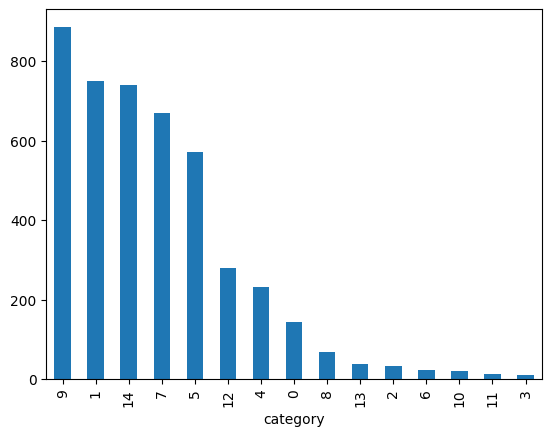

In [72]:
def plot_category_distribution(data_df):
    category_counts = data_df['category'].value_counts()
    category_counts.plot(kind='bar')
    plt.show()

plot_category_distribution(data_df)

In [73]:
print('Length of labels:', len(label_list))
print('Shape of the training data: ', train_data.shape)
print('Shape of the test data: ', test_data.shape)

Length of labels: 15
Shape of the training data:  (3131, 12)
Shape of the test data:  (1343, 12)


In [83]:
model_checkpoint = "albert/albert-base-v2"
max_length = 128

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [84]:
def preprocess_function(input_data):
    # Extract features from input_data
    titles = input_data['title'].tolist()
    word_count = input_data['word_count'].tolist()
    character_count = input_data['character_count'].tolist()
    bigrams = input_data['bigrams'].tolist()
    lemma = input_data['lemma'].tolist()
    pos = input_data['pos'].tolist()
    tag = input_data['tag'].tolist()
    dep = input_data['dep'].tolist()
    context_score = input_data['context_score'].tolist()
    trigger_words = input_data['trigger_words'].tolist()

    # Tokenize each title separately
    tokenized_inputs = tokenizer(titles, padding=True, truncation=True, max_length=max_length)

    # Create a Dataset object
    dataset = Dataset.from_dict({
        'text': titles,
        'label': input_data[LABEL_COLUMN].tolist(),  # Assuming the label column name is LABEL_COLUMN
        'word_count': word_count,
        'character_count': character_count,
        'bigrams': bigrams,
        'lemma': lemma,
        'pos': pos,
        'tag': tag,
        'dep': dep,
        'context_score': context_score,
        'trigger_words': trigger_words,
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask']
    })

    return dataset

In [85]:
encoded_train = preprocess_function(train_data)
encoded_test = preprocess_function(test_data)
encoded_train

Dataset({
    features: ['text', 'label', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'context_score', 'trigger_words', 'input_ids', 'attention_mask'],
    num_rows: 3131
})

In [86]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model.resize_token_embeddings(len(tokenizer)) # need to resize due to new tokens added

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30000, 128, padding_idx=0)

In [87]:
metric_name = 'f1'
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"./snapshots/{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 3,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

In [88]:
# Create the AdamW optimizer
optimizer = AdamW(model.parameters(), lr=3e-5)

# Define the number of training steps and warmup steps
num_train_steps = len(encoded_train) * 20
num_warmup_steps = int(0.1 * num_train_steps)  # 10% of total steps

# Create the linear scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [89]:
metric = evaluate.load(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="micro")

In [90]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

/opt/conda/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [91]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,2.549269,0.169025
2,No log,2.275731,0.185406
3,2.547200,2.148613,0.224125
4,2.547200,2.009754,0.233805
5,2.547200,1.666122,0.460164
6,2.066100,1.294464,0.650782
7,2.066100,1.051045,0.710350
8,1.358300,0.880371,0.760983
9,1.358300,0.792591,0.786299
10,1.358300,0.835133,0.789278


TrainOutput(global_step=3920, training_loss=1.1566040661870216, metrics={'train_runtime': 351.9544, 'train_samples_per_second': 177.921, 'train_steps_per_second': 11.138, 'total_flos': 61458724749240.0, 'train_loss': 1.1566040661870216, 'epoch': 20.0})

In [92]:
trainer.evaluate()

{'eval_loss': 0.6046743988990784,
 'eval_f1': 0.870439314966493,
 'eval_runtime': 1.3707,
 'eval_samples_per_second': 979.793,
 'eval_steps_per_second': 61.283,
 'epoch': 20.0}

In [93]:
bert_eval = trainer.evaluate(encoded_test)
bert_eval

{'eval_loss': 0.6046743988990784,
 'eval_f1': 0.870439314966493,
 'eval_runtime': 7.4922,
 'eval_samples_per_second': 179.254,
 'eval_steps_per_second': 11.212,
 'epoch': 20.0}

In [94]:
predictions = trainer.predict(encoded_test)

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.870439314966493
Precision: 0.8532564021117093
Recall: 0.870439314966493
F1: 0.8585707553889611


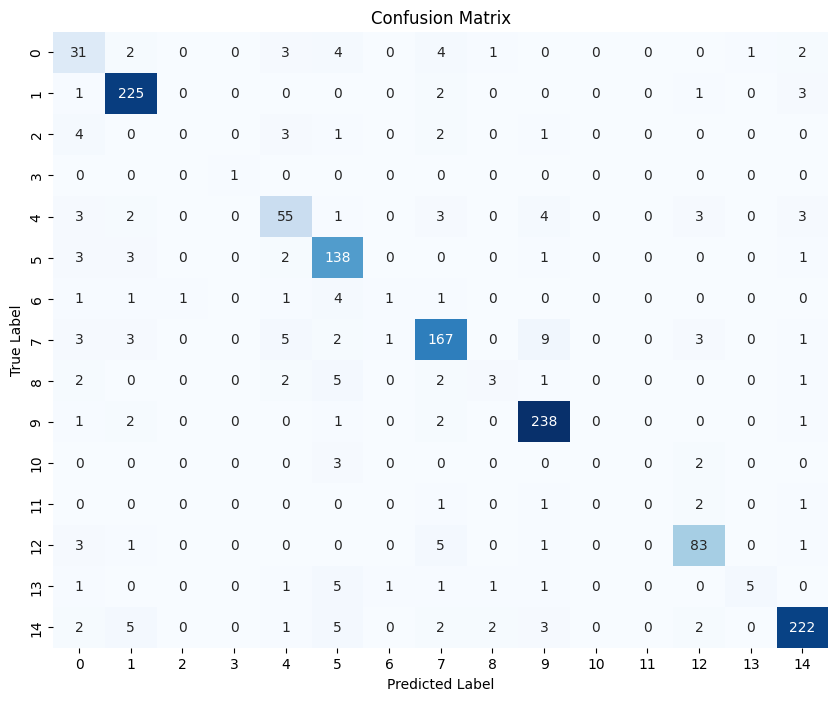

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
ground_truth_labels = encoded_test["label"]
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(y_true=ground_truth_labels, y_pred=predicted_labels)
precision = precision_score(y_true=ground_truth_labels, y_pred=predicted_labels, average='weighted')
recall = recall_score(y_true=ground_truth_labels, y_pred=predicted_labels, average='weighted')
f1 = f1_score(y_true=ground_truth_labels, y_pred=predicted_labels, average='weighted')
confusion_matrix = confusion_matrix(ground_truth_labels, predicted_labels)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()